# Prequisites

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

# Data Preparation

In [2]:
print("Number of Bikes are ",
      len(os.listdir("Car-Bike-Dataset/Bike")))
print("Number of Cars are ",
      len(os.listdir("Car-Bike-Dataset/Car")))

Number of Bikes are  2000
Number of Cars are  2000


In [2]:
#0 for Bike and 1 for Car
col1 = []
col2 = []
for i in tqdm(os.listdir("Car-Bike-Dataset\\Bike")):
    path = os.path.join("Car-Bike-Dataset\\Bike", i)
    with open("data.txt", "a") as x:
        x.write(path+"\t"+"Bike"+"\n")
        col1.append(path)
        col2.append(0)
for i in tqdm(os.listdir("Car-Bike-Dataset\\Car")):
    path = os.path.join("Car-Bike-Dataset\\Car", i)
    with open("data.txt", "a") as x:
        x.write(path+"\t"+"Car"+"\n")
        col1.append(path)
        col2.append(1)

100%|█████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4306.83it/s]


In [3]:
df = pd.DataFrame(list(zip(col1, col2)),
                  columns = ["img", "label"], index=None)

In [4]:
from torch.utils.data import Dataset
import torchvision
from torch.utils.data import DataLoader

In [5]:
class CBDataset(Dataset):
    def __init__(self, data, transform):
        self.dataset = data
        self.transform = transform
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        image = cv2.imread(self.dataset.iloc[index][0])
        #image = image.reshape(52, 52)
        image = cv2.resize(image, (52,52))
        label = self.dataset.iloc[index][1]
        if self.transform is not None:
            #image = self.transform(image.astype(np.float32))
            image = self.transform(image)
        return image, label

In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                           torchvision.transforms.ToTensor()])

train_data = CBDataset(df.iloc[0:1500],
                       transform=transform)

val_data = CBDataset(df.iloc[1500:],
                     transform= transform)

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [57]:
train_data

# Model Training

## Simple shallow ann with feature maps halved at every layer

In [32]:
model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(8112,128),
        torch.nn.Linear(128,64),
        torch.nn.Linear(64,32),
        torch.nn.Linear(32,16),
        torch.nn.Linear(16,8),
        torch.nn.Linear(8,2)
        )

In [33]:
model.modules

<bound method Module.modules of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=8112, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): Linear(in_features=16, out_features=8, bias=True)
  (6): Linear(in_features=8, out_features=2, bias=True)
)>

In [34]:
images ,labels = iter(train_loader).next()
print(images.shape)
print(model(images).shape), labels, labels.shape

torch.Size([128, 3, 52, 52])
torch.Size([128, 2])


(None,
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 torch.Size([128]))

In [42]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

In [45]:
lrs = []
val_acc = []
train_acc = []
for epoch in range(0,5):
    print("Epoch : ",epoch)
    epoch_loss = 0
    batches = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        batches+=1
        outputs=model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    inputs,targets = iter(val_loader).next()
    outputs = model(inputs).detach().numpy().argmax(axis=-1)
    val_accuracy = (outputs == targets.numpy()).mean()
    val_acc.append(val_accuracy)
    for inputs,targets in train_loader:
        outputs = model(inputs).detach().numpy().argmax(axis=-1)
        train_accuracy = (outputs == targets.numpy()).mean()
    train_accuracy = train_accuracy/batches
    train_acc.append(train_accuracy)
    print("Train accuracy on Batch of {} images is {} ".format(batches, train_accuracy))
    print("Validation accuracy on Batch of {} images is {}".format(batches, val_accuracy))
    print("Loss is ", epoch_loss)

Epoch :  0
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.1953125
Loss is  tensor(0., grad_fn=<AddBackward0>)
Epoch :  1
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.2109375
Loss is  tensor(0., grad_fn=<AddBackward0>)
Epoch :  2
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.234375
Loss is  tensor(0., grad_fn=<AddBackward0>)
Epoch :  3
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.1796875
Loss is  tensor(0., grad_fn=<AddBackward0>)
Epoch :  4
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.125
Loss is  tensor(0., grad_fn=<AddBackward0>)


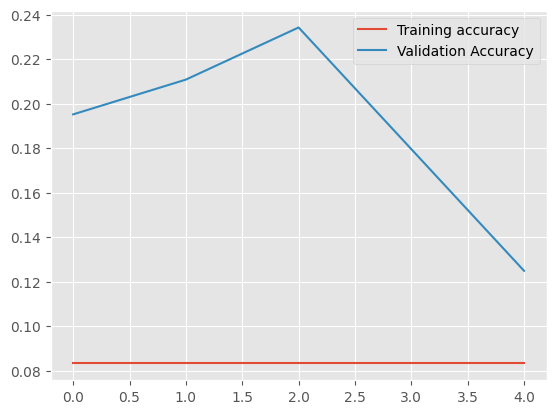

In [50]:
plt.style.use("ggplot")
plt.plot(train_acc, label="Training accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.show()

## Adding Dropouts in between tha layers 

In [54]:
model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(8112,128),
        torch.nn.Dropout(),
        torch.nn.Linear(128,64),
        torch.nn.Dropout(),
        torch.nn.Linear(64,32),
        torch.nn.Dropout(),
        torch.nn.Linear(32,16),
        torch.nn.Dropout(),
        torch.nn.Linear(16,8)
)

In [55]:
model.modules

<bound method Module.modules of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=8112, out_features=128, bias=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=32, bias=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=32, out_features=16, bias=True)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=16, out_features=8, bias=True)
)>

In [56]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

In [66]:
lrs = []
val_acc = []
train_acc = []
ep_loss = []
for epoch in range(0,10):
    print("Epoch : ",epoch)
    epoch_loss = 0
    batches = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        batches+=1
        outputs=model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    inputs,targets = iter(val_loader).next()
    outputs = model(inputs).detach().numpy().argmax(axis=-1)
    val_accuracy = (outputs == targets.numpy()).mean()
    val_acc.append(val_accuracy)
    for inputs,targets in train_loader:
        outputs = model(inputs).detach().numpy().argmax(axis=-1)
        train_accuracy = (outputs == targets.numpy()).mean()
    train_accuracy = train_accuracy/batches
    train_acc.append(train_accuracy)
    ep_loss.append(epoch_loss.detach().numpy())
    print("Train accuracy on Batch of {} images is {} ".format(batches, train_accuracy))
    print("Validation accuracy on Batch of {} images is {}".format(batches, val_accuracy))
    print("Loss is ", epoch_loss)

Epoch :  0
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.1796875
Loss is  tensor(0.2004, grad_fn=<AddBackward0>)
Epoch :  1
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.1640625
Loss is  tensor(0.1091, grad_fn=<AddBackward0>)
Epoch :  2
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.203125
Loss is  tensor(0.1189, grad_fn=<AddBackward0>)
Epoch :  3
Train accuracy on Batch of 12 images is 0.08242753623188405 
Validation accuracy on Batch of 12 images is 0.2265625
Loss is  tensor(0.1593, grad_fn=<AddBackward0>)
Epoch :  4
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.2109375
Loss is  tensor(0.3159, grad_fn=<AddBackward0>)
Epoch :  5
Train accuracy on Batch of 12 images is 0.08333333333333333 
Validation accuracy on Batch of 12 images is 0.234375


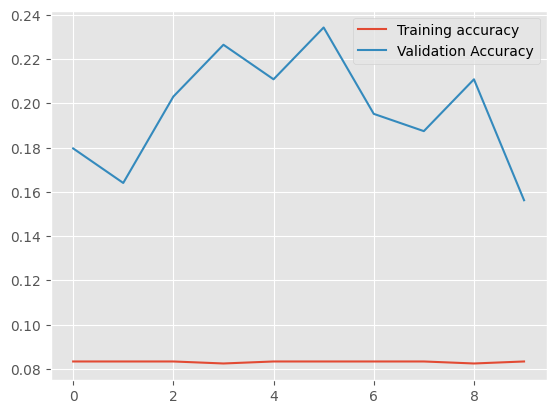

In [67]:
plt.style.use("ggplot")
plt.plot(train_acc, label="Training accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.show()

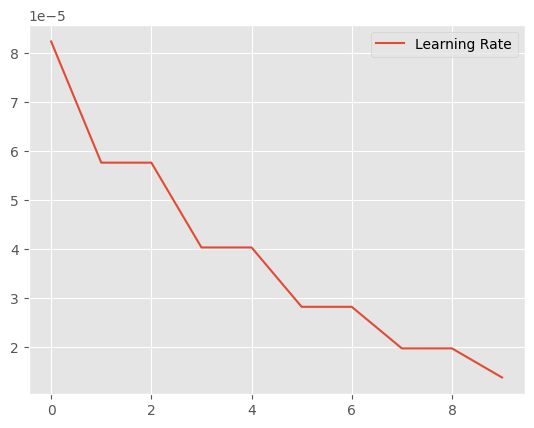

In [68]:
plt.plot(lrs, label="Learning Rate")
plt.legend()

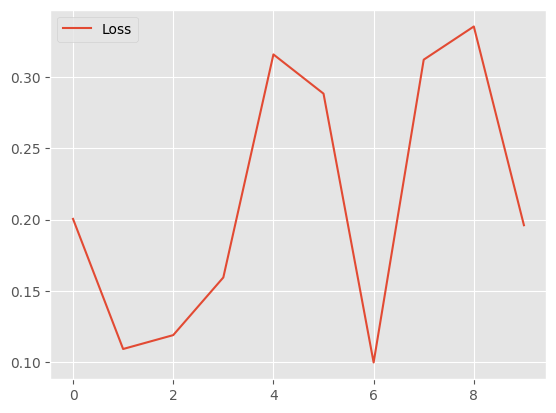

In [71]:
plt.plot(ep_loss, label = "Loss")
plt.legend()

## Basic Convolutional Neural Networks for Training

In [13]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, 3, stride=1, padding=1),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(32,64,kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Dropout(p=0.6),
    torch.nn.Linear(13,128*64*13),
    torch.nn.BatchNorm2d(64)
)

In [ ]:
inputs, targets = iter(train_loader).next()
model(inputs).shape

In [174]:
model.modules

<bound method Module.modules of Sequential(
  (0): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(1, 1, kernel_size=(10, 10), stride=(2, 2))
  (4): Conv2d(1, 2, kernel_size=(10, 10), stride=(5, 5))
  (5): ReLU()
  (6): Linear(in_features=3, out_features=2, bias=True)
)>

In [175]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

In [176]:
lrs = []
val_acc = []
train_acc = []
ep_loss = []
for epoch in range(0,10):
    print("Epoch : ",epoch)
    epoch_loss = 0
    batches = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        batches+=1
        outputs=model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    inputs,targets = iter(val_loader).next()
    outputs = model(inputs).detach().numpy().argmax(axis=-1)
    val_accuracy = (outputs == targets.numpy()).mean()
    val_acc.append(val_accuracy)
    for inputs,targets in train_loader:
        outputs = model(inputs).detach().numpy().argmax(axis=-1)
        train_accuracy = (outputs == targets.numpy()).mean()
    train_accuracy = train_accuracy/batches
    train_acc.append(train_accuracy)
    ep_loss.append(epoch_loss.detach().numpy())
    print("Train accuracy on Batch of {} images is {} ".format(batches, train_accuracy))
    print("Validation accuracy on Batch of {} images is {}".format(batches, val_accuracy))
    print("Loss is ", epoch_loss)

Epoch :  0


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1